# Statistical Analysis & Visualization

This notebook performs statistical analysis on the results of different optimization algorithms (NSGA-II, GA, mu+lambda, SA) applied to the hospital path planning problem.

**Objective:** Determine if the observed differences in performance are statistically significant or due to random chance (luck).

**Methodology:**
- **Data Source:** `results/combined/all_algorithms_combined.csv`
- **Primary Metric:** `best_clean` (Real distance without penalty). This allows a fair "apples-to-apples" comparison across single-objective and multi-objective algorithms.
- **Tests:** 
    - Normality check (Shapiro-Wilk)
    - Significance test (Kruskal-Wallis / ANOVA)
    - Post-hoc pairwise comparison (Dunn's test)
    - 95% Confidence Intervals (Bootstrap/T-dist)

## 1. Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp

# Ensure output directories exist
os.makedirs('../plots/comparative', exist_ok=True)
os.makedirs('../validation_report', exist_ok=True)

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported and directories checked.")

Libraries imported and directories checked.


## 2. Load Data (From DB - Legacy/Optional)
*This section is kept for compatibility but main analysis uses CSVs below.*

In [ ]:
import sqlite3

def load_from_db(db_path, algo_name):
    try:
        if os.path.exists(db_path):
            con = sqlite3.connect(db_path)
            df = pd.read_sql_query("SELECT * FROM runs", con)
            con.close()
            df['algorithm'] = algo_name
            return df
        return None
    except Exception as e:
        print(f"Error loading {algo_name}: {e}")
        return None

# Attempt to load from DBs (just to print status)
db_files = {
    'NSGA-II': '../data/nsga2_experiments.db',
    'GA': '../data/ga_experiments.db',
    'μ+λ': '../data/mulambda_experiments.db',
    'SA': '../data/sa_experiments.db'
}

for algo, path in db_files.items():
    df_tmp = load_from_db(path, algo)
    if df_tmp is not None:
        print(f"DB found for {algo}: {len(df_tmp)} records")
    else:
        print(f"DB NOT found for {algo}")

## 3. Load Data from CSV (Primary Source)
We load the combined results containing `best_clean` for all algorithms. This ensures we compare exactly the same metric.

In [3]:
CSV_PATH = '../results/combined/all_algorithms_combined.csv'

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded data from {CSV_PATH}")
    print(f"Total runs: {len(df)}")
    print("\nAlgorithms found:")
    print(df['algorithm'].value_counts())
    
    # Preview
    print("\nData Preview:")
    print(df.head())
else:
    raise FileNotFoundError(f"CRITICAL: Results file not found at {CSV_PATH}. Please run experiments first.")

Loaded data from ../results/combined/all_algorithms_combined.csv
Total runs: 124

Algorithms found:
algorithm
NSGA-II    31
GA         31
μ+λ        31
SA         31
Name: count, dtype: int64

Data Preview:
  algorithm  best_fitness   best_clean    time_sec
0   NSGA-II   1103.193001  1085.193001  386.591481
1   NSGA-II   1175.429797  1100.979797  393.946214
2   NSGA-II   1237.785642  1161.435642  394.148334
3   NSGA-II   1134.144011  1103.394011  394.777181
4   NSGA-II   1150.435137  1129.335137  395.162473


## 4. Statistical Confidence Analysis

We calculate the **95% Confidence Interval** for the mean `best_clean` distance. 
- **Narrow interval:** High confidence in the result (consistent performance).
- **Wide interval:** Low confidence (results depend heavily on "luck"/seed).

In [4]:
def get_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

comparison_metric = 'best_clean'

stats_summary = []

print(f"--- Confidence Analysis (Metric: {comparison_metric}) ---\n")

for algo in df['algorithm'].unique():
    subset = df[df['algorithm'] == algo][comparison_metric]
    mean_val, lower, upper, margin = get_confidence_interval(subset)
    std_val = subset.std()
    min_val = subset.min()
    
    stats_summary.append({
        'Algorithm': algo,
        'Mean': mean_val,
        'Std': std_val,
        'CI_Lower': lower,
        'CI_Upper': upper,
        'Margin': margin,
        'Best_Seen': min_val,
        'Samples': len(subset)
    })
    
    print(f"Algorithm: {algo:8s} | Mean: {mean_val:.2f} ± {margin:.2f} (95% CI: [{lower:.2f}, {upper:.2f}]) | Best: {min_val:.2f}")

summary_df = pd.DataFrame(stats_summary).sort_values('Mean')

# Save summary for paper
summary_csv_path = '../validation_report/statistical_confidence_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"\nSummary saved to: {summary_csv_path}")

--- Confidence Analysis (Metric: best_clean) ---

Algorithm: NSGA-II  | Mean: 1133.90 ± 14.86 (95% CI: [1119.04, 1148.76]) | Best: 1069.98
Algorithm: GA       | Mean: 1146.93 ± 15.04 (95% CI: [1131.89, 1161.97]) | Best: 1079.32
Algorithm: μ+λ      | Mean: 1146.82 ± 14.97 (95% CI: [1131.85, 1161.79]) | Best: 1082.91
Algorithm: SA       | Mean: 1279.46 ± 30.44 (95% CI: [1249.01, 1309.90]) | Best: 1124.98

Summary saved to: ../validation_report/statistical_confidence_summary.csv


### Interpretation of Luck vs Performance

We calculate the **Coefficient of Variation (CV)** to quantify "luck":
- $CV = \frac{\sigma}{\mu} \times 100\%$
- Higher CV = Results vary wildly with seed = High dependence on luck.

  Algorithm         Mean        Std    CV (%)    Best_Seen
0   NSGA-II  1133.898812  40.508864  3.572529  1069.979797
2       μ+λ  1146.819266  40.810402  3.558573  1082.908730
1        GA  1146.932251  40.996160  3.574419  1079.322943
3        SA  1279.458741  82.999145  6.487051  1124.979797


/tmp/ipykernel_13828/2619727403.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='CV (%)', data=summary_df, palette='viridis')


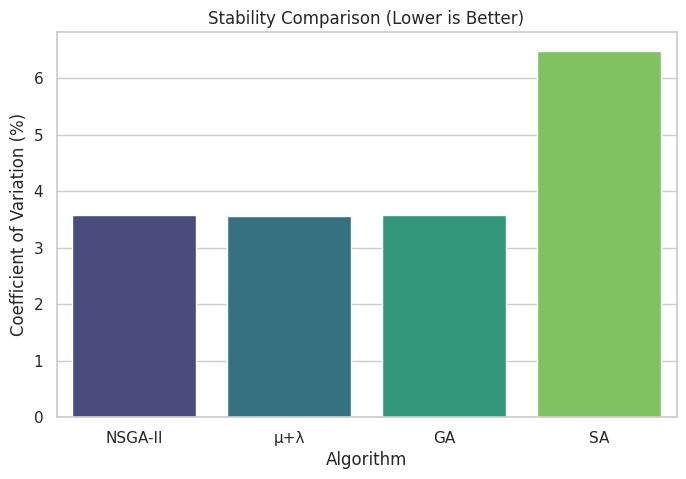

In [5]:
summary_df['CV (%)'] = (summary_df['Std'] / summary_df['Mean']) * 100
print(summary_df[['Algorithm', 'Mean', 'Std', 'CV (%)', 'Best_Seen']])

# Visualize CV
plt.figure(figsize=(8, 5))
sns.barplot(x='Algorithm', y='CV (%)', data=summary_df, palette='viridis')
plt.title('Stability Comparison (Lower is Better)')
plt.ylabel('Coefficient of Variation (%)')
plt.savefig('../plots/comparative/stability_cv.png')
plt.show()

## 5. Hypothesis Testing (Significance)

Is the best algorithm *significantly* better, or just lucky?

1. **Normality Test (Shapiro-Wilk):** Check if data follows normal distribution.
2. **Kruskal-Wallis Test:** Non-parametric ANOVA equivalent (since data is often not normal in GA).
3. **Dunn's Post-hoc:** Pairwise comparison to find exactly *which* algorithms differ.

--- Shapiro-Wilk Normality Test ---
NSGA-II : p=0.0516 (Normal)
GA      : p=0.0672 (Normal)
μ+λ     : p=0.0120 (Not Normal)
SA      : p=0.8271 (Normal)

Conclusion: Data is NOT consistently Normal. Using Non-Parametric tests.

--- Kruskal-Wallis Test ---
H-statistic: 57.07, p-value: 2.4797e-12
RESULT: Significant difference found among algorithms (p < 0.05).

--- Post-hoc Dunn's Test (Pairwise) ---
                   GA       NSGA-II            SA           μ+λ
GA       1.000000e+00  1.000000e+00  1.261767e-08  1.000000e+00
NSGA-II  1.000000e+00  1.000000e+00  1.411737e-10  1.000000e+00
SA       1.261767e-08  1.411737e-10  1.000000e+00  9.408337e-08
μ+λ      1.000000e+00  1.000000e+00  9.408337e-08  1.000000e+00


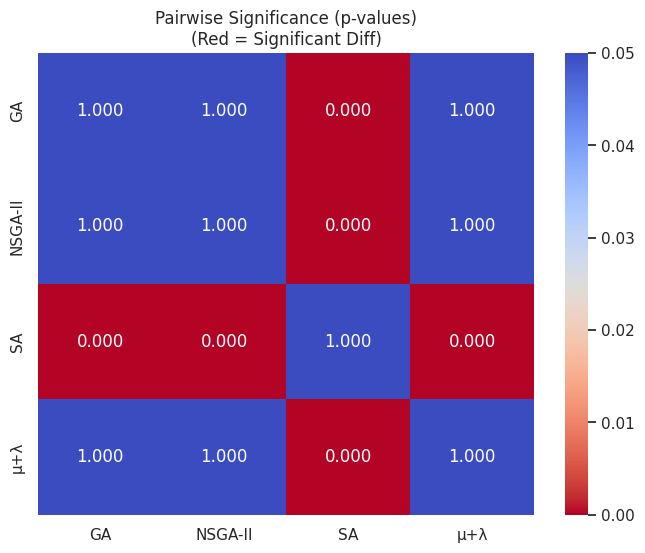

In [6]:
# 1. Normality
print("--- Shapiro-Wilk Normality Test ---")
parametrics_ok = True
for algo in df['algorithm'].unique():
    stat, p = stats.shapiro(df[df['algorithm'] == algo][comparison_metric])
    print(f"{algo:8s}: p={p:.4f} ({'Normal' if p > 0.05 else 'Not Normal'})")
    if p < 0.05: parametrics_ok = False

print(f"\nConclusion: Data is {'Normal' if parametrics_ok else 'NOT consistently Normal'}. Using Non-Parametric tests.")

# 2. Kruskal-Wallis
groups = [df[df['algorithm'] == a][comparison_metric] for a in df['algorithm'].unique()]
stat, p_kw = stats.kruskal(*groups)

print(f"\n--- Kruskal-Wallis Test ---")
print(f"H-statistic: {stat:.2f}, p-value: {p_kw:.4e}")
if p_kw < 0.05:
    print("RESULT: Significant difference found among algorithms (p < 0.05).")
    
    # 3. Post-hoc Dunn's Test
    print("\n--- Post-hoc Dunn's Test (Pairwise) ---")
    dunn = sp.posthoc_dunn(df, val_col=comparison_metric, group_col='algorithm', p_adjust='bonferroni')
    print(dunn)
    
    # Save heatmap of p-values
    plt.figure(figsize=(8, 6))
    sns.heatmap(dunn, annot=True, cmap='coolwarm_r', fmt='.3f', vmin=0, vmax=0.05)
    plt.title('Pairwise Significance (p-values)\n(Red = Significant Diff)')
    plt.savefig('../plots/comparative/significance_heatmap.png')
    plt.show()
else:
    print("RESULT: No significant difference found. Any observed difference is likely random noise.")

## 6. Comparative Visualizations

Visualizing the distributions to verify the statistical findings.

/tmp/ipykernel_13828/1011064763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='algorithm', y=comparison_metric, data=df, palette='Set2')
/tmp/ipykernel_13828/1011064763.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xtick, means[xtick] + vertical_offset, f'{means[xtick]:.1f}',


AttributeError: module 'matplotlib' has no attribute 'patheffects'

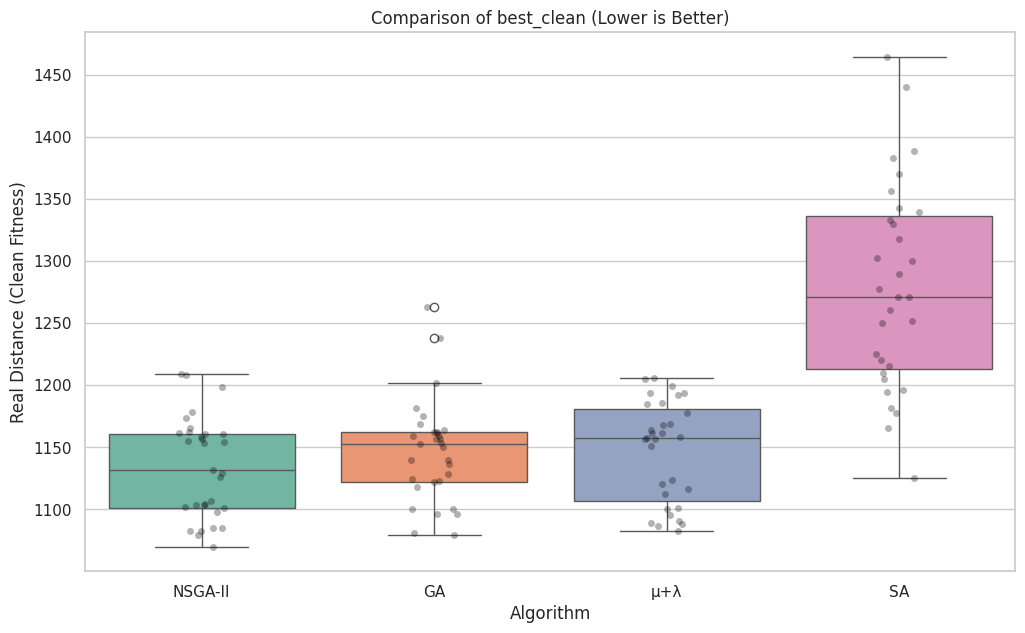

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='algorithm', y=comparison_metric, data=df, palette='Set2')
sns.stripplot(x='algorithm', y=comparison_metric, data=df, color='black', alpha=0.3, jitter=True)

plt.title(f'Comparison of {comparison_metric} (Lower is Better)')
plt.ylabel('Real Distance (Clean Fitness)')
plt.xlabel('Algorithm')

# Add mean values as labels
means = df.groupby(['algorithm'])[comparison_metric].mean()
vertical_offset = df[comparison_metric].mean() * 0.01

for xtick in plt.gca().get_xticks():
    plt.text(xtick, means[xtick] + vertical_offset, f'{means[xtick]:.1f}', 
             horizontalalignment='center', color='w', weight='bold', 
             path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground='k')])

plt.savefig('../plots/comparative/boxplot_best_clean.png')
plt.show()

## 7. Generate Paper Report

Auto-generating a LaTeX table snippet for the paper.

In [8]:
latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|c|c|c|}\n\\hline\n"
latex_table += "Algorithm & Mean Clean Distance (95\\% CI) & Best Observed & Stability (CV) \\\\\n\\hline\n"

for _, row in summary_df.iterrows():
    ci_str = f"[{row['CI_Lower']:.1f}, {row['CI_Upper']:.1f}]"
    latex_table += f"{row['Algorithm']} & {row['Mean']:.1f} $\\pm$ {row['Margin']:.1f} & {row['Best_Seen']:.1f} & {row['CV (%)']:.1f}\\% \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Statistical comparison of clean distance fitness across 30 runs.}\n\\label{tab:alg_comparison}\n\\end{table}"

with open('../validation_report/table_results.tex', 'w') as f:
    f.write(latex_table)

print("LaTeX table generated at: ../validation_report/table_results.tex")
print(latex_table)

LaTeX table generated at: ../validation_report/table_results.tex
\begin{table}[h!]
\centering
\begin{tabular}{|l|c|c|c|}
\hline
Algorithm & Mean Clean Distance (95\% CI) & Best Observed & Stability (CV) \\
\hline
NSGA-II & 1133.9 $\pm$ 14.9 & 1070.0 & 3.6\% \\
μ+λ & 1146.8 $\pm$ 15.0 & 1082.9 & 3.6\% \\
GA & 1146.9 $\pm$ 15.0 & 1079.3 & 3.6\% \\
SA & 1279.5 $\pm$ 30.4 & 1125.0 & 6.5\% \\
\hline
\end{tabular}
\caption{Statistical comparison of clean distance fitness across 30 runs.}
\label{tab:alg_comparison}
\end{table}
